In [2]:
import pandas as pd
import numpy as np
import IPython.display as ipd
from speechbrain.pretrained import EncoderClassifier
import os 
import librosa
import torch
import matplotlib.pyplot as plt


torchvision is not available - cannot save figures


In [3]:
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech

processor = SpeechT5Processor.from_pretrained("/data3/abraham/tts/tts/src/experiments/wav2vec2-large-xlsr-53-discriminative-asr-accent-weighted-9-1/checkpoints")
model = SpeechT5ForTextToSpeech.from_pretrained("/data3/abraham/tts/tts/src/experiments/wav2vec2-large-xlsr-53-discriminative-asr-accent-weighted-9-1/checkpoints")

In [4]:
device ="cuda:0"
def get_speaker_model(spk_model_name):

    speaker_model = EncoderClassifier.from_hparams(
        source=spk_model_name,
        run_opts={"device": device},
        savedir=os.path.join("/tmp", spk_model_name)
    )
    return speaker_model

def create_speaker_embedding( speech):
    speaker_model = get_speaker_model("speechbrain/spkrec-xvect-voxceleb")
    
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(speech).to(device))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().to("cpu").numpy()
    return speaker_embeddings

In [5]:
!dir /data3/data/AfriSpeech-TTS/dev/8b4472ce-d533-46b4-a90f-ffceb4657bd3/b742a15fb23dfdee788efa3f71523627_dVyNA9rN.wav

/data3/data/AfriSpeech-TTS/dev/8b4472ce-d533-46b4-a90f-ffceb4657bd3/b742a15fb23dfdee788efa3f71523627_dVyNA9rN.wav


In [6]:
path = "/data3/data/AfriSpeech-TTS/dev/8b4472ce-d533-46b4-a90f-ffceb4657bd3/b742a15fb23dfdee788efa3f71523627_dVyNA9rN.wav"
sample, sr = librosa.load(path, sr=16000)

In [7]:
speaker_embeddings= create_speaker_embedding(sample)
speaker_embeddings

/home/ubuntu/anaconda3/envs/tts/lib/python3.10/site-packages/torch/functional.py:641: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:862.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


array([-8.06265026e-02,  2.29601990e-02,  2.09316220e-02,  1.90430563e-02,
        2.68161856e-02, -1.80583429e-02, -4.04230542e-02,  1.00634284e-02,
        7.48060271e-02,  1.60903633e-02, -5.67842983e-02, -7.49493614e-02,
        8.08372051e-02,  5.26140071e-03,  3.79152820e-02,  6.43425733e-02,
       -6.01645978e-03,  4.61583659e-02,  7.72266556e-03, -1.32664945e-02,
        2.62476187e-02,  2.75137126e-02, -1.84039231e-02, -3.48725468e-02,
       -4.44555581e-02, -7.10170344e-03, -3.97902355e-02,  9.85404011e-03,
        2.42416505e-02,  1.08493436e-02, -2.14300025e-03,  5.63128665e-02,
        3.92208472e-02, -2.08843704e-02,  4.37344275e-02, -4.47021127e-02,
        6.48512691e-02,  6.89006150e-02, -6.38616388e-04, -7.73499012e-02,
        6.04623556e-02, -1.96937006e-02,  2.77170297e-02,  4.93206158e-02,
        1.59366224e-02, -1.13308042e-01, -2.16943901e-02,  1.19992588e-02,
       -6.87308684e-02,  3.52731161e-02,  2.63414029e-02,  4.90890965e-02,
        2.92138383e-02,  

In [8]:
speaker_embeddings = torch.tensor(speaker_embeddings).unsqueeze(0)
speaker_embeddings.shape

torch.Size([1, 512])

In [9]:
text = "I am going to the hospital today"

In [10]:
inputs = processor(text=text, return_tensors="pt")

In [14]:
spectrogram = model.generate_speech(inputs["input_ids"], speaker_embeddings)

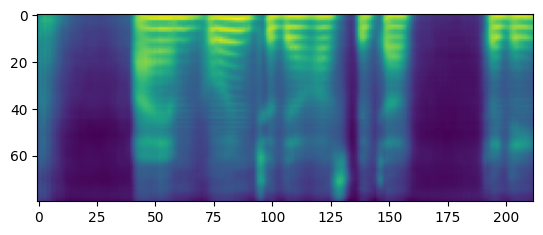

In [15]:
plt.figure()
plt.imshow(spectrogram.T)
plt.show()

In [16]:
from transformers import SpeechT5HifiGan
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")

In [17]:
with torch.no_grad():
    speech = vocoder(spectrogram)

In [19]:
from IPython.display import Audio
Audio(path, rate=16000)

In [18]:
from IPython.display import Audio
Audio(speech.numpy(), rate=16000)

# Denoising training  analysis

In [13]:
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech
model_path = "/data3/abraham/tts/AfriSpeech-TTS/src/experiments/afri_tts_speech_t5_denoised/checkpoints/checkpoint-19500"
processor = SpeechT5Processor.from_pretrained(model_path)
model = SpeechT5ForTextToSpeech.from_pretrained(model_path)


device ="cuda:0"
def get_speaker_model(spk_model_name):

    speaker_model = EncoderClassifier.from_hparams(
        source=spk_model_name,
        run_opts={"device": device},
        savedir=os.path.join("/tmp", spk_model_name)
    )
    return speaker_model

def create_speaker_embedding( speech):
    speaker_model = get_speaker_model("speechbrain/spkrec-xvect-voxceleb")
    
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(speech).to(device))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().to("cpu").numpy()
    return speaker_embeddings



In [8]:
audio_path = "/data3/data/AfriSpeech-TTS/dev/8b4472ce-d533-46b4-a90f-ffceb4657bd3/b742a15fb23dfdee788efa3f71523627_dVyNA9rN.wav"
sample, sr = librosa.load(audio_path, sr=16000)


speaker_embeddings= create_speaker_embedding(sample)
speaker_embeddings



array([-8.06263760e-02,  2.29603034e-02,  2.09310874e-02,  1.90431476e-02,
        2.68158410e-02, -1.80581752e-02, -4.04231921e-02,  1.00638289e-02,
        7.48063400e-02,  1.60903540e-02, -5.67842349e-02, -7.49493912e-02,
        8.08373466e-02,  5.26147196e-03,  3.79153974e-02,  6.43425435e-02,
       -6.01643743e-03,  4.61584926e-02,  7.72266695e-03, -1.32663772e-02,
        2.62475815e-02,  2.75134221e-02, -1.84039120e-02, -3.48728560e-02,
       -4.44555394e-02, -7.10170576e-03, -3.97903882e-02,  9.85411182e-03,
        2.42419764e-02,  1.08493054e-02, -2.14300072e-03,  5.63129485e-02,
        3.92210335e-02, -2.08843611e-02,  4.37341407e-02, -4.47021537e-02,
        6.48509711e-02,  6.89005777e-02, -6.38137048e-04, -7.73497522e-02,
        6.04625493e-02, -1.96937192e-02,  2.77172104e-02,  4.93207201e-02,
        1.59366839e-02, -1.13307960e-01, -2.16943771e-02,  1.19992523e-02,
       -6.87308386e-02,  3.52732167e-02,  2.63414532e-02,  4.90891598e-02,
        2.92138755e-02,  

In [9]:

text = "i am going to the hospital today"

inputs = processor(text=text, return_tensors="pt")

spectrogram = model.generate_speech(inputs["input_ids"], speaker_embeddings)

plt.figure()
plt.imshow(spectrogram.T)
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'norm'

In [1]:
!python --version 

Python 2.7.17
